# Predicción del Consumo de Agua en Zonas de Cultivo – Driscoll's México
Este notebook descarga datos reales de evapotranspiración desde la NASA POWER API para estimar el consumo de agua en zonas agrícolas ubicadas cerca de Zamora, Michoacán, donde Driscoll’s tiene presencia.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Coordenadas aproximadas de Zamora, Michoacán
lat, lon = 19.99, -102.28

# Rango de fechas
start_date = "2022-01-01"
end_date = "2022-12-31"

In [7]:
url = (
    f"https://power.larc.nasa.gov/api/temporal/daily/point"
    f"?parameters=PET&community=ag&longitude={lon}&latitude={lat}"
    f"&start={start_date.replace('-', '')}&end={end_date.replace('-', '')}&format=JSON"
)

response = requests.get(url)
data = response.json()

In [8]:
et0_data = pd.DataFrame.from_dict(data['properties']['parameter']['ET0'], orient='index', columns=['ET0'])
et0_data.index = pd.to_datetime(et0_data.index)
et0_data = pd.DataFrame.from_dict(data['properties']['parameter']['PET'], orient='index', columns=['PET'])
et0_data.head()

KeyError: 'properties'

In [9]:
print(data)

{'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['One of your parameters is incorrect: PET.']}


In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Coordenadas aproximadas de una zona de cultivo de Driscoll's en Jalisco, México
latitude = 20.5
longitude = -103.5

# Fechas de inicio y fin
start_date = '20240101'
end_date = '20241231'

# Parámetros disponibles en la API de NASA POWER para la comunidad AG (Agroclimatología)
# Puedes consultar la lista completa de parámetros en: https://power.larc.nasa.gov/docs/services/api/temporal/daily/
parameters = 'T2M,T2M_MAX,T2M_MIN,ALLSKY_SFC_SW_DWN,WS2M,PRECTOTCORR'

# Construir la URL de la solicitud
url = f'https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters}&community=AG&longitude={longitude}&latitude={latitude}&start={start_date}&end={end_date}&format=JSON'

# Realizar la solicitud a la API
response = requests.get(url)
data = response.json()

# Extraer los datos de los parámetros
df = pd.DataFrame(data['properties']['parameter'])

# Transponer el DataFrame para tener las fechas como índice
df = df.transpose()

# Convertir el índice a formato de fecha
df.index = pd.to_datetime(df.index)

# Mostrar las primeras filas del DataFrame
print(df.head())

# Graficar la temperatura media diaria
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['T2M'], label='Temperatura Media (°C)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura Media Diaria')
plt.legend()
plt.grid(True)
plt.show()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-01-01 00:02:00 present at position 0

In [ ]:
# Supongamos 10 hectáreas de cultivo
area_ha = 10

# Cálculo del volumen total en m³
consumo_total_m3 = (et0_data['ET0_mm'].sum() * area_ha * 10000) / 1000
print(f"Consumo total estimado de agua en {area_ha} ha en {start_date[:4]}: {consumo_total_m3:.2f} m³")

In [ ]:
et0_data['ET0_mm'].plot(title='Evapotranspiración Diaria (mm)', figsize=(10,5))
plt.xlabel('Fecha')
plt.ylabel('ET0 (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()


🍓 Analizando Fresa
  📍 Santa María, CA: 17.44 MJ/m²/día
  📍 Centro México: 21.36 MJ/m²/día

🍓 Analizando Arándano
  📍 California: 18.46 MJ/m²/día
  📍 Baja/Centro México: 23.37 MJ/m²/día

🍓 Analizando Zarzamora
  📍 Baja California: 27.23 MJ/m²/día
  📍 Centro México: 19.31 MJ/m²/día

🍓 Analizando Frambuesa
  📍 Baja California: 21.63 MJ/m²/día
  📍 Centro México: 22.33 MJ/m²/día


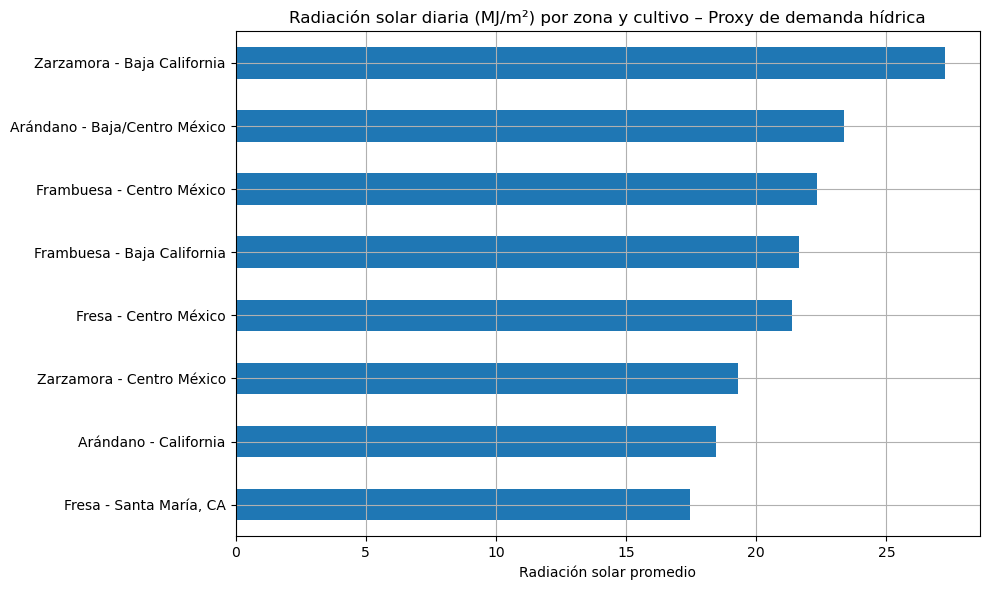

In [12]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# 📍 Ubicaciones y meses activos por fruta
frutas = {
    "Fresa": {
        "Santa María, CA": {"lat": 34.95, "lon": -120.44, "meses": [11,12,1,2,3,4,5,6,7]},
        "Centro México": {"lat": 20.3, "lon": -102.3, "meses": [1,2,3,4,5,10,11,12]},
    },
    "Arándano": {
        "California": {"lat": 36.9, "lon": -121.7, "meses": list(range(1,13))},
        "Baja/Centro México": {"lat": 25.0, "lon": -105.0, "meses": [1,2,3,4,5,6]},
    },
    "Zarzamora": {
        "Baja California": {"lat": 30.6, "lon": -115.9, "meses": [4,5,6,7,8]},
        "Centro México": {"lat": 20.0, "lon": -102.0, "meses": [1,2,3,10,11,12]},
    },
    "Frambuesa": {
        "Baja California": {"lat": 30.6, "lon": -115.9, "meses": list(range(1,13))},
        "Centro México": {"lat": 20.0, "lon": -102.0, "meses": list(range(1,13))},
    },
}

start_date = "20230101"
end_date = "20231231"

# ⚠️ Usamos radiación solar como proxy de ET0 (ET se relaciona con radiación y temperatura)
def obtener_radiacion(lat, lon):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN&community=AG&longitude={lon}&latitude={lat}&start={start_date}&end={end_date}&format=JSON"
    r = requests.get(url)
    data = r.json()
    if "properties" not in data:
        print("❌ Error con coordenadas:", lat, lon)
        return pd.Series(dtype="float")
    serie = pd.Series(data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"])
    serie.index = pd.to_datetime(serie.index)
    return serie

resultados = {}

for fruta, zonas in frutas.items():
    print(f"\n🍓 Analizando {fruta}")
    for zona, info in zonas.items():
        rad = obtener_radiacion(info["lat"], info["lon"])
        rad_mes = rad[rad.index.month.isin(info["meses"])]
        promedio = rad_mes.mean()
        print(f"  📍 {zona}: {promedio:.2f} MJ/m²/día")
        resultados[f"{fruta} - {zona}"] = promedio

# Mostrar comparativa en gráfico
pd.Series(resultados).sort_values().plot(kind="barh", figsize=(10,6), title="Radiación solar diaria (MJ/m²) por zona y cultivo – Proxy de demanda hídrica", xlabel="Radiación solar promedio", grid=True)
plt.tight_layout()
plt.show()

In [14]:
import requests
import pandas as pd
from datetime import datetime

# Zonas actualizadas con coordenadas verificadas
zonas = {
    "Fresa": {
        "zonas": {
            "Santa María, CA": {"lat": 34.95, "lon": -120.44},
            "Centro México": {"lat": 20.3, "lon": -102.3}
        },
        "meses": [11,12,1,2,3,4,5,6,7]
    },
    "Arándano": {
        "zonas": {
            "California": {"lat": 36.9, "lon": -121.7},
            "Baja/Centro México": {"lat": 25.0, "lon": -105.0}
        },
        "meses": [1,2,3,4,5,6]
    },
    "Zarzamora": {
        "zonas": {
            "Baja California": {"lat": 30.6, "lon": -115.9},
            "Centro México": {"lat": 20.0, "lon": -102.0}
        },
        "meses": [4,5,6,7,8]
    },
    "Frambuesa": {
        "zonas": {
            "Baja California": {"lat": 30.6, "lon": -115.9},
            "Centro México": {"lat": 20.0, "lon": -102.0}
        },
        "meses": list(range(1,13))
    }
}

def obtener_radiacion(lat, lon, start_date, end_date):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "start": start_date,
        "end": end_date,
        "latitude": lat,
        "longitude": lon,
        "community": "AG",
        "parameters": "ALLSKY_SFC_SW_DWN",
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        try:
            radiacion = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
            df = pd.DataFrame.from_dict(radiacion, orient='index', columns=['Radiacion'])
            df.index = pd.to_datetime(df.index)
            df['Radiacion'] = pd.to_numeric(df['Radiacion'], errors='coerce')
            df = df[df['Radiacion'] > -900]  # Filtrar -999 y errores
            return df
        except KeyError:
            print(f"❌ Error en los datos para coordenadas: {lat}, {lon}")
            return pd.DataFrame()
    else:
        print(f"❌ Error en la solicitud para coordenadas: {lat}, {lon}")
        return pd.DataFrame()

# Obtener el año actual
año_actual = datetime.now().year
start_date = f"{año_actual}0101"
end_date = f"{año_actual}1231"

# Análisis por fruta y zona
for fruta, info in zonas.items():
    print(f"\n🍓 Analizando {fruta}")
    for zona, coords in info["zonas"].items():
        df_radiacion = obtener_radiacion(coords["lat"], coords["lon"], start_date, end_date)
        if not df_radiacion.empty:
            df_filtrado = df_radiacion[df_radiacion.index.month.isin(info["meses"])]
            promedio = df_filtrado['Radiacion'].mean()
            print(f"  📍 {zona}: {promedio:.2f} MJ/m²/día")
        else:
            print(f"  📍 {zona}: Datos no disponibles")


🍓 Analizando Fresa
  📍 Santa María, CA: 16.84 MJ/m²/día
  📍 Centro México: 22.65 MJ/m²/día

🍓 Analizando Arándano
  📍 California: 15.25 MJ/m²/día
  📍 Baja/Centro México: 21.93 MJ/m²/día

🍓 Analizando Zarzamora
  📍 Baja California: 26.07 MJ/m²/día
  📍 Centro México: 27.87 MJ/m²/día

🍓 Analizando Frambuesa
  📍 Baja California: 19.57 MJ/m²/día
  📍 Centro México: 22.65 MJ/m²/día


In [15]:
print("\n💧 Estimación del consumo de agua por hectárea (litros/día):")

for fruta, info in zonas.items():
    print(f"\n🌱 {fruta}")
    for zona, coords in info["zonas"].items():
        df_radiacion = obtener_radiacion(coords["lat"], coords["lon"], start_date, end_date)
        if not df_radiacion.empty:
            df_filtrado = df_radiacion[df_radiacion.index.month.isin(info["meses"])]
            promedio_rad = df_filtrado['Radiacion'].mean()
            if promedio_rad > 0:
                et0_mm_dia = 0.408 * promedio_rad
                litros_ha_dia = et0_mm_dia * 10_000
                print(f"  📍 {zona}: {litros_ha_dia:,.0f} L/ha/día (ET₀ = {et0_mm_dia:.2f} mm)")
            else:
                print(f"  📍 {zona}: radiación no válida")
        else:
            print(f"  📍 {zona}: Datos no disponibles")


💧 Estimación del consumo de agua por hectárea (litros/día):

🌱 Fresa
  📍 Santa María, CA: 68,698 L/ha/día (ET₀ = 6.87 mm)
  📍 Centro México: 92,420 L/ha/día (ET₀ = 9.24 mm)

🌱 Arándano
  📍 California: 62,200 L/ha/día (ET₀ = 6.22 mm)
  📍 Baja/Centro México: 89,460 L/ha/día (ET₀ = 8.95 mm)

🌱 Zarzamora
  📍 Baja California: 106,351 L/ha/día (ET₀ = 10.64 mm)
  📍 Centro México: 113,713 L/ha/día (ET₀ = 11.37 mm)

🌱 Frambuesa
  📍 Baja California: 79,836 L/ha/día (ET₀ = 7.98 mm)
  📍 Centro México: 92,420 L/ha/día (ET₀ = 9.24 mm)


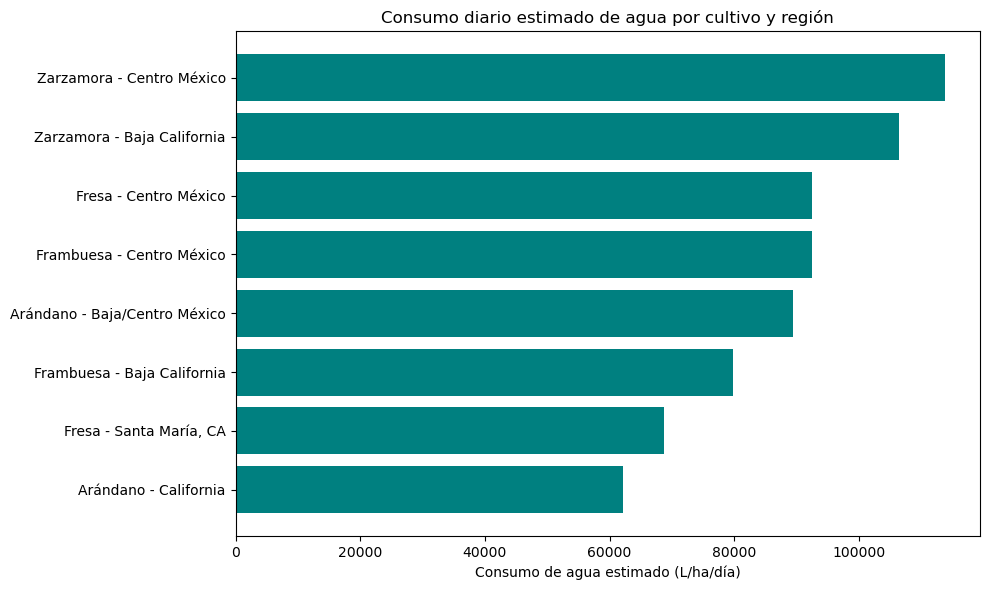

In [16]:
import matplotlib.pyplot as plt

# Datos de consumo en litros por hectárea por día
datos_consumo = {
    "Fresa - Santa María, CA": 68698,
    "Fresa - Centro México": 92420,
    "Arándano - California": 62200,
    "Arándano - Baja/Centro México": 89460,
    "Zarzamora - Baja California": 106351,
    "Zarzamora - Centro México": 113713,
    "Frambuesa - Baja California": 79836,
    "Frambuesa - Centro México": 92420
}

# Ordenar por consumo para una visualización clara
datos_ordenados = dict(sorted(datos_consumo.items(), key=lambda x: x[1], reverse=True))

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.barh(list(datos_ordenados.keys()), list(datos_ordenados.values()), color='teal')
plt.xlabel("Consumo de agua estimado (L/ha/día)")
plt.title("Consumo diario estimado de agua por cultivo y región")
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar el mayor consumo arriba
plt.tight_layout()
plt.show()

Resumen estadístico de 'Lectura m3':
count      586.000000
mean      4196.102661
std       4045.732861
min          0.000000
25%        174.187125
50%       3154.000000
75%       6571.330000
max      15460.000000
Name: Lectura m3, dtype: float64

Matriz de correlación:
              Semana       Año  Lectura m3  Hectareas
Semana      1.000000  0.262853    0.308609   0.710400
Año         0.262853  1.000000   -0.028095   0.236875
Lectura m3  0.308609 -0.028095    1.000000   0.336591
Hectareas   0.710400  0.236875    0.336591   1.000000


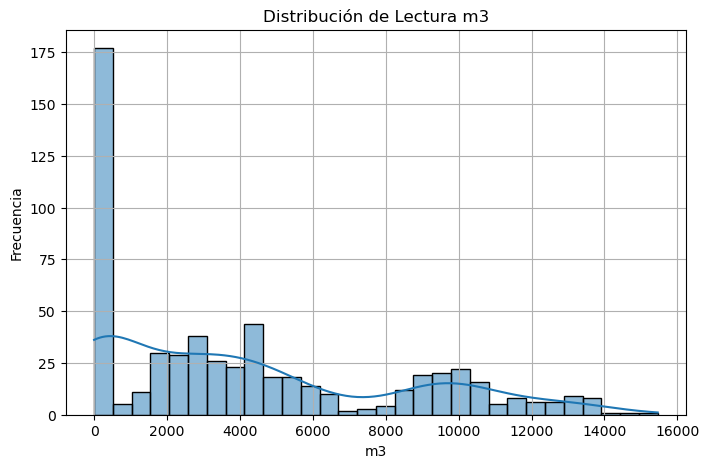

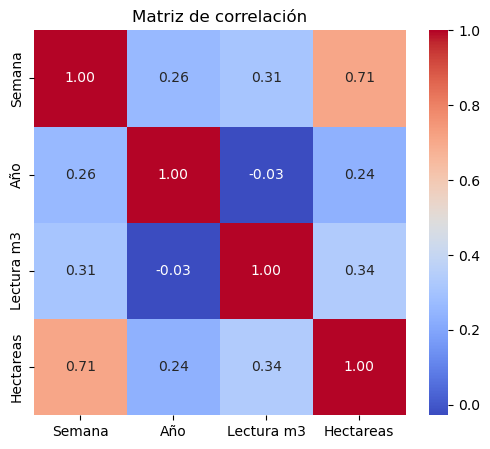

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar archivo y hoja
df = pd.read_excel("Reto TEC DB Driscolls.xlsx", sheet_name="Ranchos")

# Estadísticas descriptivas
print("Resumen estadístico de 'Lectura m3':")
print(df["Lectura m3"].describe())

# Matriz de correlación
num_df = df.select_dtypes(include=["number"])
corr = num_df.corr()
print("\nMatriz de correlación:")
print(corr)

# Histograma de Lectura m3
plt.figure(figsize=(8, 5))
sns.histplot(df["Lectura m3"], bins=30, kde=True)
plt.title("Distribución de Lectura m3")
plt.xlabel("m3")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Mapa de calor de correlación
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [1]:
import pandas as pd

# Cargar datos
df = pd.read_excel("Reto TEC DB Driscolls.xlsx", sheet_name="Ranchos")

# Separar variables numéricas y categóricas
num_cols = df.select_dtypes(include=['number'])
cat_cols = df.select_dtypes(include=['object'])

# Correlación con variables numéricas
print("📊 Correlación con variables numéricas:")
print(num_cols.corr()["Lectura m3"].sort_values(ascending=False))

# Impacto de variables categóricas en promedio de Lectura m3
print("\n📈 Promedio de Lectura m3 por categoría:\n")
for col in cat_cols.columns:
    grouped = df.groupby(col)["Lectura m3"].mean().sort_values(ascending=False)
    print(f"\n▶️ {col}")
    print(grouped)

📊 Correlación con variables numéricas:
Lectura m3    1.000000
Hectareas     0.336591
Semana        0.308609
Año          -0.028095
Name: Lectura m3, dtype: float64

📈 Promedio de Lectura m3 por categoría:


▶️ Cultivo
Cultivo
BLACK    8316.615385
RASP     2241.515728
BLUE     1279.746070
STRAW     145.405018
Name: Lectura m3, dtype: float64

▶️ Rancho
Rancho
Colibri          9806.608696
Rancho Nuevo     9534.044444
San Agustin      6274.830000
Eliza            4855.666667
Apuente viejo    4319.392857
Los Espinos      3198.875000
Bambu            3065.333333
ROSITA           2566.538462
S1Tamandaro      1271.888889
EL MORAL          109.348329
Name: Lectura m3, dtype: float64

▶️ Zona de Produccion
Zona de Produccion
Tuxcueca         9806.608696
Jacona           8157.018519
Tapalpa          6274.830000
Guzmán           4855.666667
Los Reyes        4319.392857
Zamora           3198.875000
Jocotepec        3065.333333
Ciudad Guzmán    2566.538462
Tangancicuaro     109.348329
Name: Lectura

R² Score: 0.8796861772268494
RMSE: 1425.185379493127


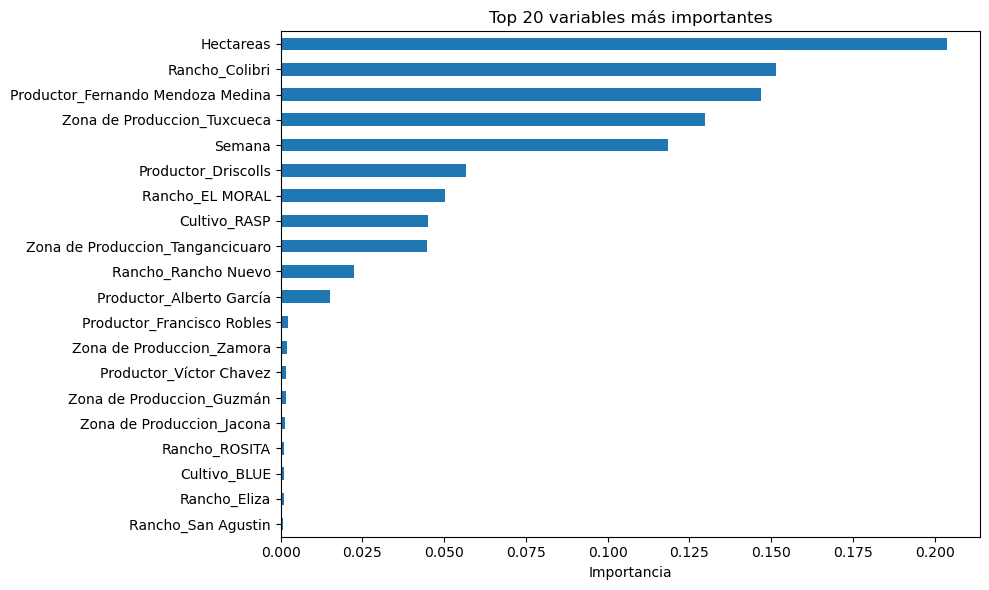

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_excel("Reto TEC DB Driscolls.xlsx", sheet_name="Ranchos")

# Variables elegidas
features = [
    "Semana", "Hectareas", "Zona de Produccion", "Tipo de campo", 
    "Medio", "Productor", "Cultivo", "Rancho"
]
target = "Lectura m3"

# Eliminar registros nulos
df = df[features + [target]].dropna()

# Codificar variables categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Dividir en X e y
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Evaluación
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Importancia de variables
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
importances.head(20).plot(kind="barh")
plt.title("Top 20 variables más importantes")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [4]:
print(df.columns.tolist())

['Cultivo', 'Rancho', 'Zona de Produccion', 'Tipo de campo', 'Medio', 'Productor', 'Latitud', 'Longitud', 'Fecha', 'Semana', 'Año', 'Lectura m3', 'Etapa', 'Hectareas', 'Detalles']


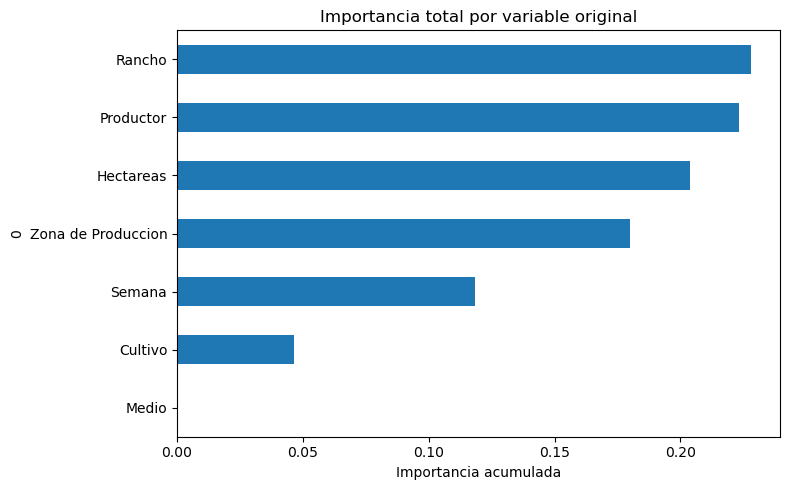

In [6]:
# Agrupar importancia de variables dummies por su variable original
grouped_importance = importances.copy()

# Extraer nombre base antes del "_" para columnas dummy (ej. 'Productor', 'Zona de Produccion', etc.)
grouped_importance.index = grouped_importance.index.to_series().str.extract(r"^([^\_]+)")[0]

# Agrupar y sumar importancias
grouped_summary = grouped_importance.groupby(grouped_importance.index).sum().sort_values(ascending=False)

# Graficar importancias agrupadas
plt.figure(figsize=(8, 5))
grouped_summary.plot(kind="barh")
plt.title("Importancia total por variable original")
plt.xlabel("Importancia acumulada")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


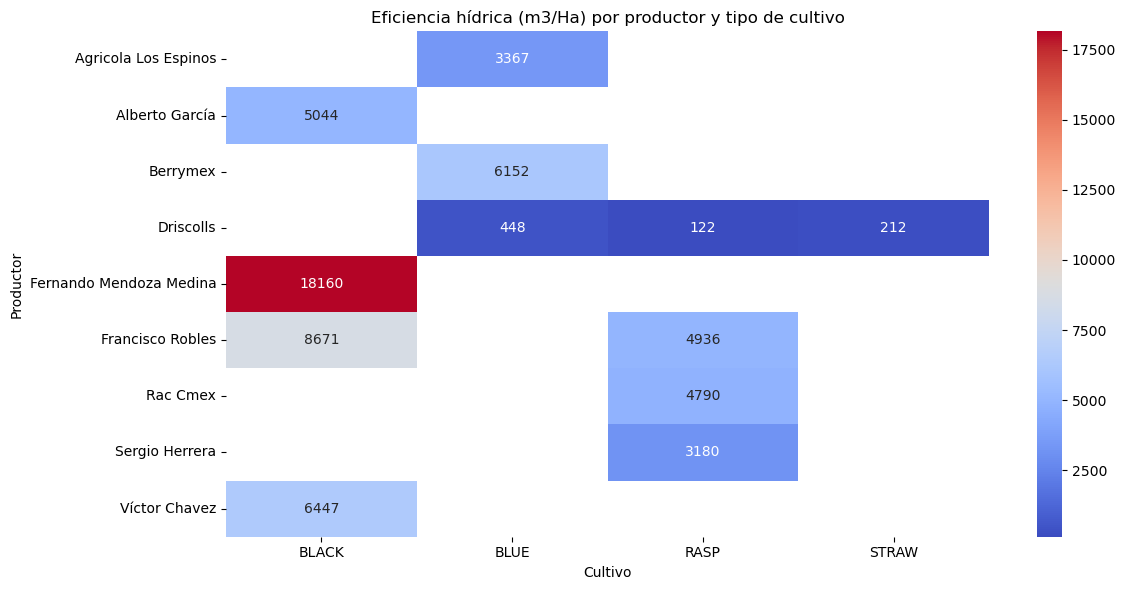

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_excel("Reto TEC DB Driscolls.xlsx", sheet_name="Ranchos")

# Filtrar columnas necesarias
df = df[["Productor", "Cultivo", "Lectura m3", "Hectareas"]].dropna()

# Calcular eficiencia hídrica
df["m3_por_hectarea"] = df["Lectura m3"] / df["Hectareas"]

# Agrupar por productor y cultivo
pivot = df.groupby(["Productor", "Cultivo"])["m3_por_hectarea"].mean().unstack()

# Visualizar como heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Eficiencia hídrica (m3/Ha) por productor y tipo de cultivo")
plt.xlabel("Cultivo")
plt.ylabel("Productor")
plt.tight_layout()
plt.show()

In [10]:
print(df.columns.tolist())

['Productor', 'Cultivo', 'Lectura m3', 'Hectareas', 'm3_por_hectarea']


In [11]:
# Asegurar que los nombres estén limpios
df.columns = df.columns.str.strip()

# Ordenar por Productor, Cultivo y Lectura (asumiendo que lectura va aumentando en el tiempo)
df = df.sort_values(by=["Productor", "Cultivo", "Lectura m3"])

# Calcular diferencia para obtener m3 usados esa semana
df["m3_usados"] = df.groupby(["Productor", "Cultivo"])["Lectura m3"].diff()

# Calcular eficiencia real semanal
df["m3_por_hectarea"] = df["m3_usados"] / df["Hectareas"]

# Eliminar primeras filas sin diferencia
df = df.dropna(subset=["m3_usados"])

# Mostrar resultado
df[["Productor", "Cultivo", "m3_usados", "m3_por_hectarea"]].head()

,Productor,Cultivo,m3_usados,m3_por_hectarea
269,Agricola Los Espinos,BLUE,52.0,54.736842
262,Agricola Los Espinos,BLUE,54.0,56.842105
270,Agricola Los Espinos,BLUE,62.0,65.263158
263,Agricola Los Espinos,BLUE,420.0,442.105263
271,Agricola Los Espinos,BLUE,267.0,281.052632


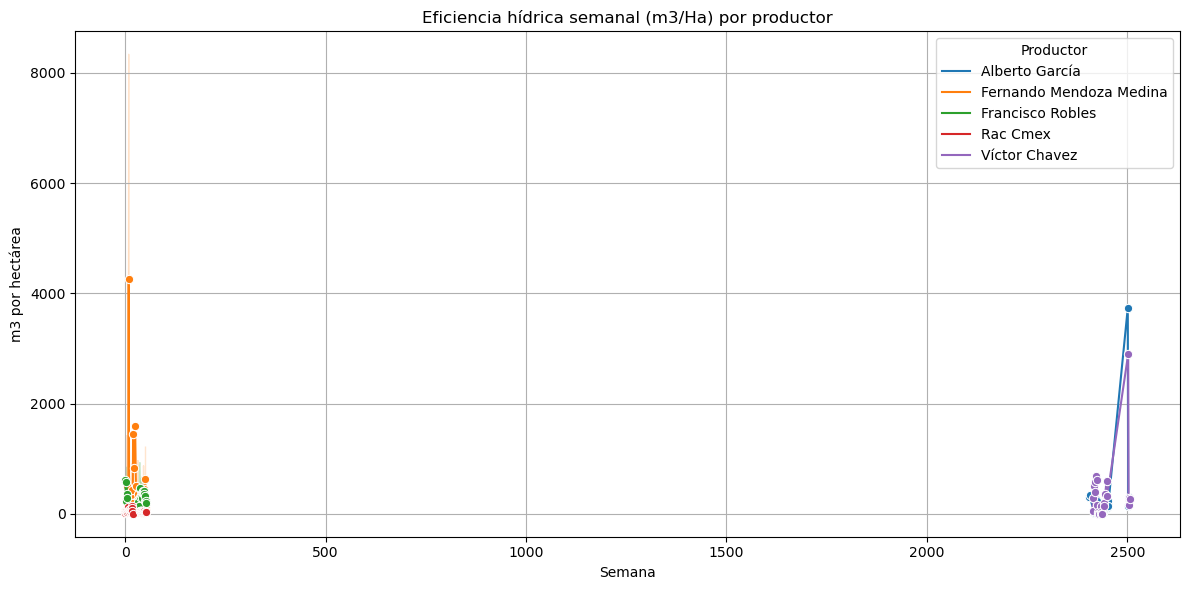

🔁 Número de ciclos de siembra detectados por productor:
Productor
Agricola Los Espinos       2
Alberto García             2
Fernando Mendoza Medina    2
Francisco Robles           2
Víctor Chavez              2
Berrymex                   1
Rac Cmex                   1
Sergio Herrera             1
Name: ciclo_id, dtype: int64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar y limpiar columnas
df = pd.read_excel("Reto TEC DB Driscolls.xlsx", sheet_name="Ranchos")
df.columns = df.columns.str.strip()
df = df[["Fecha", "Semana", "Productor", "Cultivo", "Lectura m3", "Hectareas"]].dropna()
df["Fecha"] = pd.to_datetime(df["Fecha"], dayfirst=True, errors="coerce")

# Ordenar
df = df.sort_values(by=["Productor", "Cultivo", "Fecha"])

# Detectar reinicio = nuevo ciclo si lectura acumulada baja
df["nuevo_ciclo"] = df.groupby(["Productor", "Cultivo"])["Lectura m3"].diff().lt(0).fillna(True).astype(int)
df["ciclo_id"] = df.groupby(["Productor", "Cultivo"])["nuevo_ciclo"].cumsum()

# Calcular m3 usados y eficiencia
df["m3_usados"] = df.groupby(["Productor", "Cultivo", "ciclo_id"])["Lectura m3"].diff()
df["m3_por_hectarea"] = df["m3_usados"] / df["Hectareas"]

# Filtrar valores válidos
df = df.dropna(subset=["m3_usados", "m3_por_hectarea"])

# ----------------------------
# 1. Gráfico eficiencia semanal por productor
# ----------------------------
plt.figure(figsize=(12, 6))
top_producers = df["Productor"].value_counts().head(5).index.tolist()
sns.lineplot(data=df[df["Productor"].isin(top_producers)],
             x="Semana", y="m3_por_hectarea", hue="Productor", marker="o")
plt.title("Eficiencia hídrica semanal (m3/Ha) por productor")
plt.ylabel("m3 por hectárea")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 2. Estimar cuántos ciclos tiene cada productor
# ----------------------------
ciclos = df.groupby("Productor")["ciclo_id"].nunique().sort_values(ascending=False)
print("🔁 Número de ciclos de siembra detectados por productor:")
print(ciclos)

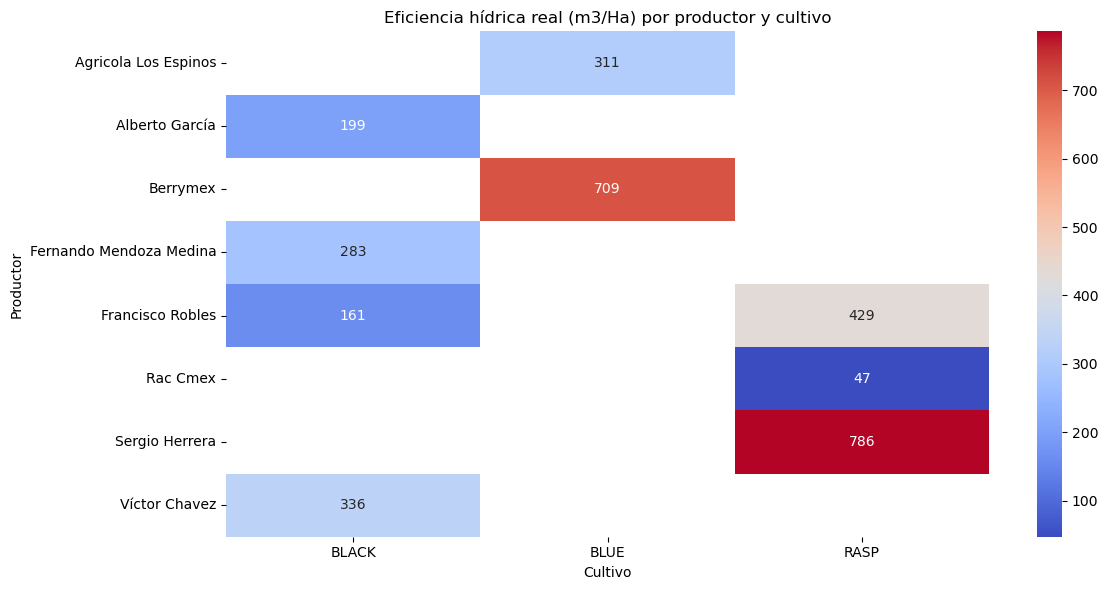

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar por productor y cultivo usando los valores reales
pivot = df.groupby(["Productor", "Cultivo"])["m3_por_hectarea"].mean().unstack()

# Visualización
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Eficiencia hídrica real (m3/Ha) por productor y cultivo")
plt.xlabel("Cultivo")
plt.ylabel("Productor")
plt.tight_layout()
plt.show()

In [16]:
df[df["Productor"].str.contains("Driscolls", case=False)][["Fecha", "Cultivo", "Lectura m3", "m3_usados", "m3_por_hectarea"]].sort_values("Fecha")

,Fecha,Cultivo,Lectura m3,m3_usados,m3_por_hectarea


In [17]:
import pandas as pd

# Cargar la base simulada
df = pd.read_csv("base_fake.csv", parse_dates=["Fecha"])

# Agregar columnas temporales útiles
df["Año"] = df["Fecha"].dt.year
df["Mes"] = df["Fecha"].dt.month

# Revisar estructura
print(df.head())

      Productor Cultivo Zona de Produccion  Semana      Fecha  Litros_usados  \
0  BLACK_Prod_1   BLACK          Jocotepec       1 2023-01-01             59   
1  BLACK_Prod_1   BLACK          Jocotepec       2 2023-01-08             71   
2  BLACK_Prod_1   BLACK          Jocotepec       3 2023-01-15             73   
3  BLACK_Prod_1   BLACK          Jocotepec       4 2023-01-22             82   
4  BLACK_Prod_1   BLACK          Jocotepec       5 2023-01-29             73   

    Año  Mes  
0  2023    1  
1  2023    1  
2  2023    1  
3  2023    1  
4  2023    1  


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Variables de entrada
features = ["Semana", "Mes", "Año", "Cultivo", "Zona de Produccion"]
df_model = pd.get_dummies(df[features + ["Litros_usados"]], drop_first=True)

# Separar X e y
X = df_model.drop("Litros_usados", axis=1)
y = df_model["Litros_usados"]

# Entrenar modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [19]:
import numpy as np

# Crear dataframe para predecir 2025
future_weeks = pd.date_range(start="2025-01-01", periods=50, freq="W")
pred_rows = []

for _, row in df[["Productor", "Cultivo", "Zona de Produccion"]].drop_duplicates().iterrows():
    for i, fecha in enumerate(future_weeks, start=1):
        pred_rows.append({
            "Semana": i,
            "Mes": fecha.month,
            "Año": 2025,
            "Cultivo": row["Cultivo"],
            "Zona de Produccion": row["Zona de Produccion"]
        })

df_pred = pd.DataFrame(pred_rows)

# Dummies como en entrenamiento
df_pred_encoded = pd.get_dummies(df_pred, drop_first=True)
df_pred_encoded = df_pred_encoded.reindex(columns=X.columns, fill_value=0)

# Predicción
df_pred["Litros_estimado"] = model.predict(df_pred_encoded)

In [20]:
# Definir rangos por percentiles
q25 = df["Litros_usados"].quantile(0.25)
q75 = df["Litros_usados"].quantile(0.75)

def clasificar_consumo(x):
    if x <= q25:
        return "Bajo"
    elif x >= q75:
        return "Alto"
    else:
        return "Normal"

df_pred["Escenario"] = df_pred["Litros_estimado"].apply(clasificar_consumo)

In [21]:
import requests

def obtener_clima(lat, lon, start, end):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,PRECTOTCORR&community=AG&longitude={lon}&latitude={lat}&start={start}&end={end}&format=JSON"
    r = requests.get(url)
    data = r.json()["properties"]["parameter"]
    df_clima = pd.DataFrame(data).T.reset_index()
    df_clima.columns = ["Fecha", "Temperatura", "Precipitacion"]
    return df_clima

# Ejemplo: zona Jocotepec
df_clima = obtener_clima(lat=20.28, lon=-103.43, start="20250101", end="20251231")
df_clima["Fecha"] = pd.to_datetime(df_clima["Fecha"])

ValueError: Length mismatch: Expected axis has 127 elements, new values have 3 elements

In [22]:
import requests
import pandas as pd

def obtener_clima(lat, lon, start, end):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,PRECTOTCORR&community=AG&longitude={lon}&latitude={lat}&start={start}&end={end}&format=JSON"
    r = requests.get(url)
    data = r.json()["properties"]["parameter"]

    df_temp = pd.DataFrame.from_dict(data["T2M"], orient="index").rename(columns={0: "Temperatura"})
    df_prec = pd.DataFrame.from_dict(data["PRECTOTCORR"], orient="index").rename(columns={0: "Precipitacion"})

    df_clima = pd.concat([df_temp, df_prec], axis=1).reset_index()
    df_clima = df_clima.rename(columns={"index": "Fecha"})
    df_clima["Fecha"] = pd.to_datetime(df_clima["Fecha"])

    return df_clima

# Llamar la función con fechas válidas y coordenadas
df_clima = obtener_clima(lat=20.28, lon=-103.43, start="20250101", end="20251231")
print(df_clima.head())

       Fecha  Temperatura  Precipitacion
0 2025-01-01        17.04           0.00
1 2025-01-02        16.10           0.00
2 2025-01-03        17.12           0.00
3 2025-01-04        16.89           0.07
4 2025-01-05        17.97           0.03


In [23]:
import numpy as np

# Calcular necesidad hídrica diaria (litros por hectárea)
df_clima["Litros_Ha_dia"] = np.maximum(0, (df_clima["Temperatura"] * 3 - df_clima["Precipitacion"]) * 10)

# Agregar semana ISO
df_clima["Semana"] = df_clima["Fecha"].dt.isocalendar().week
df_clima["Año"] = df_clima["Fecha"].dt.year

# Calcular promedio semanal (acumulado diario dividido por 7 aprox.)
df_clima_semanal = (
    df_clima.groupby(["Año", "Semana"])
    .agg({"Litros_Ha_dia": "mean"})
    .rename(columns={"Litros_Ha_dia": "Necesidad_Litros_Ha_semana"})
    .reset_index()
)

In [24]:
df_pred["Fecha"] = pd.to_datetime(df_pred["Fecha"])  # si no lo has hecho
df_pred["Semana"] = df_pred["Fecha"].dt.isocalendar().week
df_pred["Año"] = df_pred["Fecha"].dt.year

KeyError: 'Fecha'

In [25]:
# Crear fecha estimada usando Año y Semana (lunes de cada semana)
df_pred["Fecha"] = pd.to_datetime(df_pred["Año"].astype(str) + "-W" + df_pred["Semana"].astype(str) + "-1", format="%Y-W%W-%w")

In [26]:
df_pred["Semana"] = df_pred["Fecha"].dt.isocalendar().week
df_pred["Año"] = df_pred["Fecha"].dt.year

In [28]:
df_final = df_pred.merge(df_clima_semanal, on=["Año", "Semana"], how="left")
df_final["Diferencia_vs_clima"] = df_final["Litros_estimado"] - df_final["Necesidad_Litros_Ha_semana"]

In [29]:
def clasificar_gap(x):
    if x > 30:
        return "Sobreconsumo"
    elif x < -30:
        return "Subconsumo"
    else:
        return "Adecuado"

df_final["Rendimiento_vs_clima"] = df_final["Diferencia_vs_clima"].apply(clasificar_gap)

In [30]:
resumen = (
    df_final.groupby("Productor")[["Litros_estimado", "Necesidad_Litros_Ha_semana", "Diferencia_vs_clima"]]
    .mean()
    .round(1)
    .rename(columns={
        "Litros_estimado": "Consumo promedio L/Ha",
        "Necesidad_Litros_Ha_semana": "Necesidad climática L/Ha",
        "Diferencia_vs_clima": "Exceso o ahorro"
    })
)

resumen = resumen.sort_values("Exceso o ahorro", ascending=False)
print(resumen)

KeyError: 'Productor'

In [31]:
print(df_final.columns.tolist())

['Semana', 'Mes', 'Año', 'Cultivo', 'Zona de Produccion', 'Litros_estimado', 'Escenario', 'Fecha', 'Necesidad_Litros_Ha_semana', 'Diferencia_vs_clima', 'Rendimiento_vs_clima']


In [32]:
# Paso clave: asegúrate de incluir Productor desde el inicio
productores_unicos = df[["Productor", "Cultivo", "Zona de Produccion"]].drop_duplicates()

future_weeks = pd.date_range(start="2025-01-01", periods=50, freq="W")
pred_rows = []

for _, row in productores_unicos.iterrows():
    for i, fecha in enumerate(future_weeks, start=1):
        pred_rows.append({
            "Productor": row["Productor"],
            "Cultivo": row["Cultivo"],
            "Zona de Produccion": row["Zona de Produccion"],
            "Semana": i,
            "Mes": fecha.month,
            "Año": 2025,
            "Fecha": fecha
        })

df_pred = pd.DataFrame(pred_rows)

# Codificación como antes y predicción
df_pred_encoded = pd.get_dummies(df_pred[["Semana", "Mes", "Año", "Cultivo", "Zona de Produccion"]], drop_first=True)
df_pred_encoded = df_pred_encoded.reindex(columns=X.columns, fill_value=0)

df_pred["Litros_estimado"] = model.predict(df_pred_encoded)

In [33]:
# Agregar necesidad climática y diferencia
df_final = df_pred.merge(df_clima_semanal, on=["Año", "Semana"], how="left")
df_final["Diferencia_vs_clima"] = df_final["Litros_estimado"] - df_final["Necesidad_Litros_Ha_semana"]

In [34]:
resumen = (
    df_final.groupby("Productor")[["Litros_estimado", "Necesidad_Litros_Ha_semana", "Diferencia_vs_clima"]]
    .mean()
    .round(1)
    .rename(columns={
        "Litros_estimado": "Consumo promedio L/Ha",
        "Necesidad_Litros_Ha_semana": "Necesidad climática L/Ha",
        "Diferencia_vs_clima": "Exceso o ahorro"
    })
)

In [35]:
df_final.to_csv("prediccion_vs_clima_2025.csv", index=False)

In [36]:
resumen = (
    df_final.groupby("Productor")[["Litros_estimado", "Necesidad_Litros_Ha_semana", "Diferencia_vs_clima"]]
    .mean()
    .round(1)
    .rename(columns={
        "Litros_estimado": "Consumo promedio L/Ha",
        "Necesidad_Litros_Ha_semana": "Necesidad climática L/Ha",
        "Diferencia_vs_clima": "Exceso o ahorro"
    })
)

# Separar top 5 sobreconsumos y subconsumos
top_5_sobre = resumen.sort_values("Exceso o ahorro", ascending=False).head(5)
top_5_sub = resumen.sort_values("Exceso o ahorro").head(5)

# Combinar para graficar
resumen_grafico = pd.concat([top_5_sobre, top_5_sub])
resumen_grafico["Color"] = ["#d62728"] * 5 + ["#2ca02c"] * 5  # rojo y verde

# Gráfico
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="Exceso o ahorro", y=resumen_grafico.index, palette=resumen_grafico["Color"])
plt.axvline(0, color="gray", linestyle="--")
plt.title("Top 5 productores con mayor y menor eficiencia vs. clima")
plt.xlabel("Litros por hectárea (promedio semanal 2025)")
plt.ylabel("Productor")
plt.tight_layout()
plt.show()

ValueError: Could not interpret input 'Exceso o ahorro'

<Figure size 1000x600 with 0 Axes>

In [37]:
df_pred = pd.DataFrame(pred_rows)  # pred_rows debe contener "Productor"

In [38]:
df_final = df_pred.merge(df_clima_semanal, on=["Año", "Semana"], how="left")
df_final["Diferencia_vs_clima"] = df_final["Litros_estimado"] - df_final["Necesidad_Litros_Ha_semana"]

KeyError: 'Litros_estimado'

In [39]:
print(df_pred.columns.tolist())

['Productor', 'Cultivo', 'Zona de Produccion', 'Semana', 'Mes', 'Año', 'Fecha']


In [40]:
# Asumiendo que X.columns contiene las columnas usadas al entrenar el modelo
df_pred_encoded = pd.get_dummies(df_pred[["Semana", "Mes", "Año", "Cultivo", "Zona de Produccion"]], drop_first=True)
df_pred_encoded = df_pred_encoded.reindex(columns=X.columns, fill_value=0)

# Predecir con modelo entrenado
df_pred["Litros_estimado"] = model.predict(df_pred_encoded)

In [41]:
df_final = df_pred.merge(df_clima_semanal, on=["Año", "Semana"], how="left")
df_final["Diferencia_vs_clima"] = df_final["Litros_estimado"] - df_final["Necesidad_Litros_Ha_semana"]

In [42]:
print(df_final.columns.tolist())

['Productor', 'Cultivo', 'Zona de Produccion', 'Semana', 'Mes', 'Año', 'Fecha', 'Litros_estimado', 'Necesidad_Litros_Ha_semana', 'Diferencia_vs_clima']


In [43]:
resumen = (
    df_final.groupby("Productor")[["Litros_estimado", "Necesidad_Litros_Ha_semana", "Diferencia_vs_clima"]]
    .mean()
    .round(1)
    .rename(columns={
        "Litros_estimado": "Consumo promedio L/Ha",
        "Necesidad_Litros_Ha_semana": "Necesidad climática L/Ha",
        "Diferencia_vs_clima": "Exceso o ahorro"
    })
)

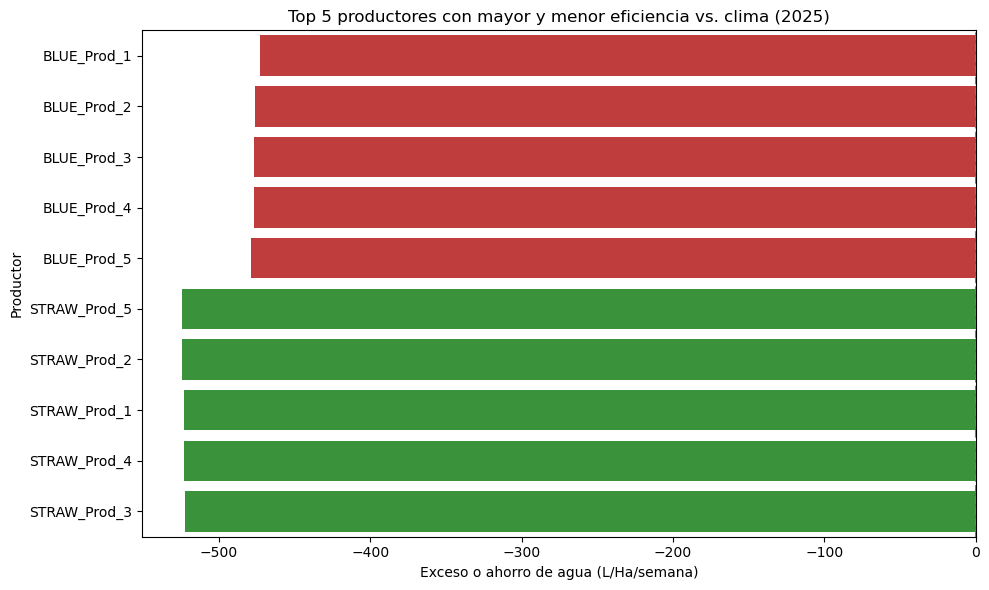

In [44]:
# Top 5 sobreconsumo / subconsumo
top_5_sobre = resumen.sort_values("Exceso o ahorro", ascending=False).head(5)
top_5_sub = resumen.sort_values("Exceso o ahorro").head(5)

# Preparar para gráfica
resumen_grafico = pd.concat([top_5_sobre, top_5_sub])
resumen_grafico["Color"] = ["#d62728"] * 5 + ["#2ca02c"] * 5  # rojo = sobreconsumo, verde = ahorro

# Gráfico
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=resumen_grafico.reset_index(),
    x="Exceso o ahorro",
    y="Productor",
    palette=resumen_grafico["Color"]
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Top 5 productores con mayor y menor eficiencia vs. clima (2025)")
plt.xlabel("Exceso o ahorro de agua (L/Ha/semana)")
plt.ylabel("Productor")
plt.tight_layout()
plt.show()

In [45]:
import folium

# Coordenadas simuladas por zona
zona_coords = {
    "Tuxcueca": (20.2, -103.4),
    "Guzmán": (19.7, -103.5),
    "Zamora": (19.98, -102.28),
    "Jocotepec": (20.28, -103.43),
    "Tangancícuaro": (19.88, -102.22)
}

# Promedio de consumo por productor y zona
map_data = (
    df_final.groupby(["Productor", "Zona de Produccion"])[["Litros_estimado", "Diferencia_vs_clima"]]
    .mean()
    .reset_index()
)

# Crear mapa base
m = folium.Map(location=[20.2, -103.3], zoom_start=7)

# Añadir círculos al mapa
for _, row in map_data.iterrows():
    zona = row["Zona de Produccion"]
    productor = row["Productor"]
    litros = row["Litros_estimado"]
    diff = row["Diferencia_vs_clima"]
    lat, lon = zona_coords.get(zona, (20.0, -103.0))

    color = "green" if diff < -30 else "red" if diff > 30 else "blue"

    folium.CircleMarker(
        location=(lat, lon),
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{productor} ({zona})<br>Consumo: {litros:.1f} L/Ha<br>Diferencia vs clima: {diff:.1f}"
    ).add_to(m)

# Guardar y mostrar
m.save("mapa_productores_consumo_2025.html")